In [1]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Load in a GeoJSON of Charlottesville census blocks
data = gpd.read_file('https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/13/query?where=1%3D1&outFields=*&outSR=4326&f=json')

In [3]:
#Load in a GeoJSON of the elementary school zone boundaries
schools = gpd.read_file('https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_1/MapServer/16/query?outFields=*&where=1%3D1&f=geojson')
schools

,OBJECTID,ZONE,geometry
0,2,Clark,"POLYGON ((-78.47802 38.02863, -78.48150 38.029..."
1,4,Jackson-Via,"POLYGON ((-78.49029 38.02682, -78.49203 38.027..."
2,5,Johnson,"POLYGON ((-78.49289 38.02676, -78.49275 38.026..."
3,6,Greenbrier,"MULTIPOLYGON (((-78.47221 38.06803, -78.47100 ..."
4,1,Burnley-Moran,"POLYGON ((-78.49375 38.03334, -78.49380 38.033..."
5,3,Venable,"POLYGON ((-78.47841 38.04517, -78.47901 38.045..."


In [4]:
#Set variables for each school's boundaries
clark = schools['geometry'][0]
jv = schools['geometry'][1]
johnson = schools['geometry'][2]
greenbrier = schools['geometry'][3]
bm = schools['geometry'][4]
venable = schools['geometry'][5]

In [5]:
#Work on this map!

m = folium.Map(location=(38.029, -78.477), zoom_start=13)

# folium.GeoJson(data,
#     style_function=lambda feature: {
#         "fillColor": "blue", 
#     },
# ).add_to(m)

# folium.LayerControl().add_to(m)

schools["style"] = [
    {"fillColor": "red", "weight": 6, "color": "red", 'fill_opacity':0.5, 'fill':True, 'popup':'Clark Elementary', 'tooltip':'Click here!'},
    {"fillColor": "orange", "weight": 2, "color": "black"},
    {"fillColor": "green", "weight": 2, "color": "black"},
    {"fillColor": "yellow", "weight": 2, "color": "black"},
    {"fillColor": "purple", "weight": 2, "color": "black"},
    {"fillColor": "blue", "weight": 2, "color": "black"},
]
folium.GeoJson(schools).add_to(m)



# folium.Polygon(
#     locations=clark_coordinates,
#     color="red",
#     weight=6,
#     fill_color="red",
#     fill_opacity=0.5,
#     fill=True,
#     popup="Clark Elementary",
#     tooltip="Click me!",
# ).add_to(m)

# folium.GeoJson(schools,  style_function=lambda feature: {
#         "fillColor": "blue", 
#     },'legend_name'="School Zones").add_to(m)

m

In [6]:
#Write a function that will label each block by its assigned school
def find_school_zone(schools, data):
    for x in range(803):
        if clark.contains(data['geometry'][x])==True:
            data['school_zone'][x]="Clark",
        elif jv.contains(data['geometry'][x])==True:
            data['school_zone'][x]="Jackson-Via",
        elif johnson.contains(data['geometry'][x])==True:
            data['school_zone'][x]="Johnson",
        elif greenbrier.contains(data['geometry'][x])==True:
            data['school_zone'][x]="Greenbrier",
        elif bm.contains(data['geometry'][x])==True:
            data['school_zone'][x]="Burnley-Moran",
        elif venable.contains(data['geometry'][x])==True:
            data['school_zone'][x]="Venable",
        else: data['school_zone'][x]="Manual"

In [7]:
#Make the new column, set a default
data['school_zone']="Manual"

In [8]:
#Run the function
pd.options.mode.chained_assignment = None
find_school_zone(schools, data)

In [9]:
#Check counts
data['school_zone'].value_counts()

Manual              196
(Venable,)          189
(Burnley-Moran,)    175
(Clark,)             78
(Greenbrier,)        66
(Jackson-Via,)       53
(Johnson,)           46
Name: school_zone, dtype: int64

In [10]:
#The function missed about 25% of zones, largely those on borders. Since the data set is rather small, I will
#refer to the visual map and input these school zones manually. In cases of a block that covers multiple attendance
#areas, I will assign to the school that has the clear majority of the zone. If a clear majority is not obvious,
#I will label it "Split".
manuals = data.loc[data['school_zone']=='Manual']

In [11]:
manuals

,OBJECTID,ID,cvgis.CITY.census_block_2010_area.AREA,Coloring,Block,BlockGroup,Tract,County,State,Block2000,...,NH18__DOJ_Asn,NH18__DOJ_Hwn,NH18__DOJ_Oth,NH18__DOJ_OthMR,Housing_Units,HU_Occupied,HU_Vacant,Sliver,geometry,school_zone
0,1,11532,NaN,1,515400006002011,515400006002,51540000600,51540,51,515400006002011,...,150,0,0,5,156,148,8,0,"POLYGON ((-78.51184 38.02624, -78.51499 38.025...",Manual
2,3,11570,NaN,0,515400006002006,515400006002,51540000600,51540,51,515400006002006,...,0,0,0,0,2,2,0,0,"POLYGON ((-78.51974 38.02846, -78.51971 38.028...",Manual
4,5,11604,NaN,1,515400006002004,515400006002,51540000600,51540,51,515400006002004,...,58,0,0,1,0,0,0,0,"POLYGON ((-78.51939 38.02846, -78.51974 38.028...",Manual
5,6,11624,NaN,0,515400006002003,515400006002,51540000600,51540,51,515400006002003,...,11,0,0,0,19,17,2,0,"POLYGON ((-78.51650 38.02864, -78.51649 38.027...",Manual
6,7,11645,NaN,1,515400006002002,515400006002,51540000600,51540,51,515400006002002,...,198,1,0,3,178,173,5,0,"POLYGON ((-78.51447 38.02871, -78.51435 38.028...",Manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,794,21144,NaN,1,515400006001003,515400006001,51540000600,51540,51,515400006001002,...,0,0,0,0,0,0,0,0,"POLYGON ((-78.49868 38.03031, -78.49887 38.030...",Manual
796,797,21200,NaN,3,515400002022009,515400002022,51540000202,51540,51,515400002022019,...,0,0,0,0,0,0,0,0,"POLYGON ((-78.49735 38.03377, -78.49754 38.033...",Manual
797,798,21218,NaN,1,515400002021030,515400002021,51540000202,51540,51,515400002021020,...,0,0,0,0,0,0,0,0,"POLYGON ((-78.49651 38.03175, -78.49655 38.031...",Manual
798,799,21238,NaN,0,515400006001001,515400006001,51540000600,51540,51,515400006001000,...,0,0,0,0,0,0,0,0,"POLYGON ((-78.49539 38.03139, -78.49547 38.031...",Manual


In [12]:
#Inputs generated by creating an ArcGIS map of the two datasets, accessed through opendata.charlottesville.org
data['school_zone'][0]='Venable'
data['school_zone'][2]='Venable'
data['school_zone'][4]='Venable'
data['school_zone'][5]='Venable'
data['school_zone'][6]='Venable'
data['school_zone'][7]='Venable'
data['school_zone'][8]='Venable'
data['school_zone'][9]='Venable'
data['school_zone'][13]='Venable'
data['school_zone'][17]='Venable'
data['school_zone'][19]='Venable'
data['school_zone'][20]='Venable'
data['school_zone'][21]='Venable'
data['school_zone'][24]='Jackson-Via'
data['school_zone'][27]='Jackson-Via'
data['school_zone'][34]='Johnson'
data['school_zone'][40]='Johnson'
data['school_zone'][42]='Jackson-Via'
data['school_zone'][47]='Split'
data['school_zone'][49]='Jackson-Via'
data['school_zone'][52]='Jackson-Via'
data['school_zone'][60]='Johnson'
data['school_zone'][62]='Jackson-Via'
data['school_zone'][65]='Johnson'
data['school_zone'][68]='Jackson-Via'
data['school_zone'][70]='Jackson-Via'
data['school_zone'][74]='Jackson-Via'
data['school_zone'][77]='Venable'
data['school_zone'][78]='Johnson'
data['school_zone'][79]='Venable'
data['school_zone'][83]='Johnson'
data['school_zone'][84]='Split'
data['school_zone'][87]='Johnson'
data['school_zone'][99]='Venable'
data['school_zone'][108]='Venable'
data['school_zone'][110]='Venable'
data['school_zone'][111]='Venable'
data['school_zone'][113]='Venable'
data['school_zone'][115]='Venable'
data['school_zone'][116]='Venable'
data['school_zone'][117]='Venable'
data['school_zone'][123]='Venable'
data['school_zone'][125]='Venable'
data['school_zone'][126]='Venable'
data['school_zone'][127]='Venable'
data['school_zone'][128]='Split'
data['school_zone'][129]='Greenbrier'
data['school_zone'][130]='Greenbrier'
data['school_zone'][131]='Venable'
data['school_zone'][132]='Venable'
data['school_zone'][133]='Venable'
data['school_zone'][135]='Venable'
data['school_zone'][158]='Jackson-Via'
data['school_zone'][166]='Johnson'
data['school_zone'][169]='Split'
data['school_zone'][174]='Jackson-Via'
data['school_zone'][176]='Clark'
data['school_zone'][177]='Clark'
data['school_zone'][178]='Clark'
data['school_zone'][179]='Jackson-Via'
data['school_zone'][183]='Jackson-Via'
data['school_zone'][193]='Jackson-Via'
data['school_zone'][196]='Split'
data['school_zone'][197]='Johnson'
data['school_zone'][198]='Johnson'
data['school_zone'][199]='Johnson'
data['school_zone'][202]='Johnson'
data['school_zone'][205]='Johnson'
data['school_zone'][206]='Clark'
data['school_zone'][209]='Clark'
data['school_zone'][210]='Jackson-Via'
data['school_zone'][212]='Clark'
data['school_zone'][214]='Clark'
data['school_zone'][225]='Greenbrier'
data['school_zone'][232]='Burnley-Moran'
data['school_zone'][233]='Burnley-Moran'
data['school_zone'][235]='Burnley-Moran'
data['school_zone'][236]='Burnley-Moran'
data['school_zone'][238]='Burnley-Moran'
data['school_zone'][239]='Burnley-Moran'
data['school_zone'][240]='Greenbrier'
data['school_zone'][246]='Greenbrier'
data['school_zone'][251]='Greenbrier'
data['school_zone'][253]='Greenbrier'
data['school_zone'][255]='Burnley-Moran'
data['school_zone'][256]='Burnley-Moran'
data['school_zone'][257]='Greenbrier'
data['school_zone'][258]='Split'
data['school_zone'][286]='Greenbrier'
data['school_zone'][288]='Split'
data['school_zone'][290]='Split'
data['school_zone'][304]='Greenbrier'
data['school_zone'][306]='Greenbrier'
data['school_zone'][311]='Greenbrier'
data['school_zone'][312]='Greenbrier'
data['school_zone'][313]='Burnley-Moran'
data['school_zone'][314]='Greenbrier'
data['school_zone'][315]='Greenbrier'
data['school_zone'][321]='Greenbrier'
data['school_zone'][344]='Split'
data['school_zone'][345]='Venable'
data['school_zone'][360]='Venable'
data['school_zone'][362]='Greenbrier'
data['school_zone'][366]='Greenbrier'
data['school_zone'][368]='Greenbrier'
data['school_zone'][369]='Venable'
data['school_zone'][371]='Greenbrier'
data['school_zone'][372]='Greenbrier'
data['school_zone'][373]='Venable'
data['school_zone'][377]='Venable'
data['school_zone'][380]='Venable'
data['school_zone'][384]='Venable'
data['school_zone'][385]='Venable'
data['school_zone'][386]='Venable'
data['school_zone'][390]='Burnley-Moran'
data['school_zone'][396]='Burnley-Moran'
data['school_zone'][398]='Burnley-Moran'
data['school_zone'][407]='Burnley-Moran'
data['school_zone'][408]='Burnley-Moran'
data['school_zone'][419]='Greenbrier'
data['school_zone'][421]='Greenbrier'
data['school_zone'][423]='Greenbrier'
data['school_zone'][425]='Greenbrier'
data['school_zone'][431]='Venable'
data['school_zone'][441]='Split'
data['school_zone'][450]='Split'
data['school_zone'][470]='Split'
data['school_zone'][472]='Split'
data['school_zone'][476]='Split'
data['school_zone'][477]='Greenbrier'
data['school_zone'][482]='Greenbrier'
data['school_zone'][484]='Greenbrier'
data['school_zone'][485]='Greenbrier'
data['school_zone'][486]='Greenbrier'
data['school_zone'][487]='Greenbrier'
data['school_zone'][488]='Greenbrier'
data['school_zone'][490]='Greenbrier'
data['school_zone'][493]='Greenbrier'
data['school_zone'][494]='Greenbrier'
data['school_zone'][495]='Greenbrier'
data['school_zone'][497]='Jackson-Via'
data['school_zone'][499]='Jackson-Via'
data['school_zone'][500]='Split'
data['school_zone'][501]='Split'
data['school_zone'][502]='Clark'
data['school_zone'][503]='Clark'
data['school_zone'][505]='Clark'
data['school_zone'][506]='Clark'
data['school_zone'][508]='Clark'
data['school_zone'][511]='Clark'
data['school_zone'][551]='Burnley-Moran'
data['school_zone'][552]='Clark'
data['school_zone'][553]='Clark'
data['school_zone'][554]='Clark'
data['school_zone'][557]='Clark'
data['school_zone'][569]='Clark'
data['school_zone'][571]='Burnley-Moran'
data['school_zone'][573]='Clark'
data['school_zone'][576]='Burnley-Moran'
data['school_zone'][618]='Burnley-Moran'
data['school_zone'][622]='Greenbrier'
data['school_zone'][623]='Greenbrier'
data['school_zone'][627]='Greenbrier'
data['school_zone'][633]='Burnley-Moran'
data['school_zone'][693]='Split'
data['school_zone'][707]='Split'
data['school_zone'][708]='Split'
data['school_zone'][709]='Venable'
data['school_zone'][710]='Burnley-Moran'
data['school_zone'][711]='Venable'
data['school_zone'][713]='Split'
data['school_zone'][715]='Split'
data['school_zone'][716]='Clark'
data['school_zone'][717]='Clark'
data['school_zone'][721]='Burnley-Moran'
data['school_zone'][722]='Burnley-Moran'
data['school_zone'][723]="Burnley-Moran"
data['school_zone'][740]="Clark"
data['school_zone'][742]='Burnley-Moran'
data['school_zone'][744]='Burnley-Moran'
data['school_zone'][745]='Clark'
data['school_zone'][748]='Burnley-Moran'
data['school_zone'][750]='Burnley-Moran'
data['school_zone'][751]='Burnley-Moran'
data['school_zone'][752]='Venable'
data['school_zone'][756]='Venable'
data['school_zone'][762]='Clark'
data['school_zone'][768]='Clark'
data['school_zone'][769]='Burnley-Moran'
data['school_zone'][779]='Johnson'
data['school_zone'][782]='Venable'
data['school_zone'][793]='Venable'
data['school_zone'][796]='Venable'
data['school_zone'][797]='Venable'
data['school_zone'][798]='Venable'
data['school_zone'][802]='Venable'
data['school_zone'][803]='Venable'

In [13]:
data['school_zone'].value_counts()

(Venable,)          189
(Burnley-Moran,)    175
(Clark,)             78
(Greenbrier,)        66
(Jackson-Via,)       53
Venable              51
(Johnson,)           46
Greenbrier           39
Burnley-Moran        29
Clark                25
Split                21
Jackson-Via          17
Johnson              14
Name: school_zone, dtype: int64

In [14]:
#The function inserted school names as tuples, so we need to standardize them
data['school_zone'] = data['school_zone'].apply(lambda x: x if type(x)==str else x[0])

In [15]:
data['school_zone'].value_counts()

Venable          240
Burnley-Moran    204
Greenbrier       105
Clark            103
Jackson-Via       70
Johnson           60
Split             21
Name: school_zone, dtype: int64

In [16]:
#Done with the shapes, so let's convert back to a standard dataframe
data.pop('geometry')
data=pd.DataFrame(data)

In [17]:
#The splits are not very helpful, so we'll drop those
data = data[data['school_zone'] != 'Split']

In [18]:
#Look at the available information
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 802
Data columns (total 381 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   OBJECTID                                int64  
 1   ID                                      int64  
 2   cvgis.CITY.census_block_2010_area.AREA  float64
 3   Coloring                                int64  
 4   Block                                   object 
 5   BlockGroup                              object 
 6   Tract                                   object 
 7   County                                  object 
 8   State                                   object 
 9   Block2000                               object 
 10  MCD                                     object 
 11  SubMCD                                  object 
 12  Place                                   object 
 13  ConCity                                 object 
 14  VTD                                     o

In [19]:
#Some of the information is irrelevant; some of it is the same for all rows; and some of it is repetitive.
#We will start with a selection of what seem like the most relevant features for our problem.
columns = ['BlockGroup', 'Population', 'White', 'Black', 'AmIndian', 'Asian', 'Hawaiian', 'Other', 'WhtBlk','Housing_Units', 'HU_Occupied', 'school_zone']
data = data[columns]

In [20]:
#Import additional information from the Virginia Equity Project. Most of this data was initially collected by the 
#U.S. Census. This data is only recorded at the block group level, so it is less granular than the first data set.
blocks = pd.read_csv('data/regional_atlas_block_groups.csv')

#Check to see what information is included
for col in blocks.columns:
    print(col)

Unnamed: 0
GEO_LEVEL
GEOID
STATEFP
COUNTYFP
COUNTYNS
NAME.x
NAMELSAD
LSAD
CLASSFP
MTFCC
CSAFP
CBSAFP
METDIVFP
FUNCSTAT
ALAND
AWATER
INTPTLAT
INTPTLON
NAME
year
totalpopE
totalpopM
whiteE
whiteM
blackE
blackM
asianE
asianM
indigE
indigM
othraceE
othraceM
multiE
multiM
ltnxE
ltnxM
povrateE
povrateM
cpovrateE
cpovrateM
hhincE
hhincM
hsmoreE
hsmoreM
bamoreE
bamoreM
gradmoreE
gradmoreM
unempE
unempM
hlthinsE
hlthinsM
pubinsE
pubinsM
earnE
earnM
giniE
giniM
vachseE
vachseM
allhseE
allhseM
snapE
snapM
foreignbE
foreignbM
renter30E
renter30M
homeownE
homeownM
vacrateE
vacrateM
perc_snaphseE
perc_snaphseM
perc_forbE
perc_forbM
schlE
schlM
age17E
age17M
age24E
age24M
age64E
age64M
age65E
age65M
hhinc_blackE
hhinc_blackM
hhinc_asianE
hhinc_asianM
hhinc_multiE
hhinc_multiM
hhinc_whiteE
hhinc_whiteM
hhinc_ltnxE
hhinc_ltnxM
disability_numE
disability_numM
fips
lifeexpE
lifeexpM
lifeexp_blackE
lifeexp_blackM
lifeexp_ltnxE
lifeexp_ltnxM
lifeexp_whiteE
lifeexp_whiteM
lifeexp_asianE
lifeexp_asianM
dissi

In [21]:
#This data is for the larger region, and we want to zoom in on just the city of Charlottesville
blocks['county.nice'].value_counts()

Albemarle County        84
Charlottesville City    38
Louisa County           24
Fluvanna County         16
Greene County           12
Nelson County           12
Name: county.nice, dtype: int64

In [22]:
#We will make a new dataframe of just the Charlottesville block groups.
blocks.rename(columns={"county.nice": "county"}, inplace=True)
cc_blocks = blocks[blocks.county=="Charlottesville City"]
cc_blocks.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 148 to 185
Columns: 127 entries, Unnamed: 0 to pop
dtypes: float64(97), int64(22), object(8)
memory usage: 38.0+ KB


In [23]:
#Many columns are all nulls, and others repeat information we already have. Additionally there are features that 
#are not relevant to our question, like water acreage.
block_columns = ['GEOID', 'hhincE','hsmoreE', 'bamoreE', 'gradmoreE', 'unempE', 'hlthinsE', 'pubinsE', 
                 'earnE', 'vachseE', 'allhseE','snapE', 'renter30E', 'homeownE', 'vacrateE', 'age17E', 
                 'age24E', 'age64E', 'age65E']
cc_blocks = cc_blocks[block_columns]
cc_blocks

,GEOID,hhincE,hsmoreE,bamoreE,gradmoreE,unempE,hlthinsE,pubinsE,earnE,vachseE,allhseE,snapE,renter30E,homeownE,vacrateE,age17E,age24E,age64E,age65E
148,515400002011,103636.0,97.33,72.90,46.76,8.06,98.96,10.45,62847.0,25,281,4,43.9,58.2,8.9,20.75,1.04,63.88,14.33
149,515400002012,NaN,84.40,30.35,11.91,0.00,88.07,12.03,24987.0,0,543,44,50.0,30.8,0.0,13.45,19.79,48.01,17.23
150,515400002013,48409.0,90.46,62.52,13.63,10.12,89.33,1.76,NaN,24,506,6,54.3,2.5,4.7,3.53,44.71,51.06,0.71
151,515400002021,42778.0,85.41,33.02,23.92,14.47,95.04,44.33,28699.0,117,789,201,56.7,22.3,14.8,34.53,14.88,44.21,4.60
152,515400002022,19187.0,81.70,48.65,16.34,1.49,82.81,4.78,10719.0,148,955,205,85.0,0.0,15.5,4.99,59.66,33.39,1.95
153,515400002023,NaN,100.00,85.78,57.34,11.87,95.63,1.39,4110.0,0,314,0,87.3,0.0,0.0,0.26,85.30,7.09,7.35
154,515400003021,66250.0,97.05,73.66,43.18,2.97,96.01,13.48,53490.0,112,1139,55,45.6,33.6,9.8,12.08,5.61,65.16,16.34
155,515400003022,82542.0,86.88,27.49,11.09,0.00,76.40,19.44,27071.0,141,655,58,52.5,61.5,21.5,16.18,3.89,59.86,17.90
156,515400004011,55577.0,99.00,43.51,18.16,3.14,90.48,37.75,40375.0,58,834,256,58.5,35.4,7.0,27.38,3.42,58.07,11.12
157,515400004012,81406.0,88.44,40.95,21.59,12.77,86.39,28.54,32481.0,56,713,80,23.8,72.5,7.9,19.83,5.98,61.42,11.16


In [24]:
#Check our updated dataframe to see our data types and remaining nulls.
cc_blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 148 to 185
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GEOID      38 non-null     int64  
 1   hhincE     34 non-null     float64
 2   hsmoreE    38 non-null     float64
 3   bamoreE    38 non-null     float64
 4   gradmoreE  38 non-null     float64
 5   unempE     38 non-null     float64
 6   hlthinsE   38 non-null     float64
 7   pubinsE    38 non-null     float64
 8   earnE      36 non-null     float64
 9   vachseE    38 non-null     int64  
 10  allhseE    38 non-null     int64  
 11  snapE      38 non-null     int64  
 12  renter30E  37 non-null     float64
 13  homeownE   38 non-null     float64
 14  vacrateE   38 non-null     float64
 15  age17E     38 non-null     float64
 16  age24E     38 non-null     float64
 17  age64E     38 non-null     float64
 18  age65E     38 non-null     float64
dtypes: float64(15), int64(4)
memory usage: 5.9 KB


In [25]:
#Necessary setup to merge the two dataframes.
data['BlockGroup'] = data['BlockGroup'].astype(int)
data = data.rename(columns={'BlockGroup':'GEOID'})

In [26]:
#Merge the block data with the block group data, using "GEOID" as the key.
data = data.merge(cc_blocks, how='left', on='GEOID')
data

,GEOID,Population,White,Black,AmIndian,Asian,Hawaiian,Other,WhtBlk,Housing_Units,...,vachseE,allhseE,snapE,renter30E,homeownE,vacrateE,age17E,age24E,age64E,age65E
0,515400006002,377,174,33,0,144,0,3,5,156,...,121,783,28,57.0,8.3,15.5,0.74,72.23,21.64,5.39
1,515400006002,0,0,0,0,0,0,0,0,0,...,121,783,28,57.0,8.3,15.5,0.74,72.23,21.64,5.39
2,515400006002,10,8,0,0,0,0,2,0,2,...,121,783,28,57.0,8.3,15.5,0.74,72.23,21.64,5.39
3,515400006002,2,2,0,0,0,0,0,0,1,...,121,783,28,57.0,8.3,15.5,0.74,72.23,21.64,5.39
4,515400006002,195,104,28,0,55,0,2,0,0,...,121,783,28,57.0,8.3,15.5,0.74,72.23,21.64,5.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,515400006001,0,0,0,0,0,0,0,0,0,...,59,478,32,62.2,3.3,12.3,0.00,69.79,24.58,5.63
778,515400002022,83,76,1,0,6,0,0,0,18,...,148,955,205,85.0,0.0,15.5,4.99,59.66,33.39,1.95
779,515400002022,103,88,0,0,8,0,0,0,23,...,148,955,205,85.0,0.0,15.5,4.99,59.66,33.39,1.95
780,515400002022,1249,1028,73,1,105,1,15,5,447,...,148,955,205,85.0,0.0,15.5,4.99,59.66,33.39,1.95


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 781
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GEOID          782 non-null    int64  
 1   Population     782 non-null    int64  
 2   White          782 non-null    int64  
 3   Black          782 non-null    int64  
 4   AmIndian       782 non-null    int64  
 5   Asian          782 non-null    int64  
 6   Hawaiian       782 non-null    int64  
 7   Other          782 non-null    int64  
 8   WhtBlk         782 non-null    int64  
 9   Housing_Units  782 non-null    int64  
 10  HU_Occupied    782 non-null    int64  
 11  school_zone    782 non-null    object 
 12  hhincE         723 non-null    float64
 13  hsmoreE        782 non-null    float64
 14  bamoreE        782 non-null    float64
 15  gradmoreE      782 non-null    float64
 16  unempE         782 non-null    float64
 17  hlthinsE       782 non-null    float64
 18  pubinsE   

In [28]:
#Population is not very meaningful as a number, since the different blocks are of disparate sizes. I engineered a
#feature to make the number more comparable across blocks
data['Density'] = data['Population']/data['Housing_Units']
data.replace(float('inf'), 0, inplace=True)

In [29]:
#Drop our target (and a few other features we no longer need) to begin modeling
X = data.drop(['school_zone', 'GEOID', 'Population', 'Housing_Units'], axis=1)
y = data['school_zone']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=12)

In [31]:
#Let's start with dummy models.

dummy= DummyClassifier(strategy='uniform')
random_guess = dummy.fit(X_train, y_train).score(X_test, y_test)

dummy2 = DummyClassifier(strategy='most_frequent')
guessing_venable = dummy2.fit(X_train, y_train).score(X_test, y_test)

random_guess, guessing_venable

(0.15816326530612246, 0.32142857142857145)

In [32]:
#Our data will need to be scaled, and we do have two columns with some nulls. Knowing household income and 
#the percentage of burdened renters (paying more than 30% of income in rent) is useful to our question, so we 
#don't want to lose that data, so we will use a KNNImputer to fill in the few remaining null values. The model initially
#struggled to converge so we set the maximum iterations to a higher number.

pipe = Pipeline(steps=[('knn', KNNImputer()), ('scale', StandardScaler()), 
                       ('lr', LogisticRegressionCV(multi_class='multinomial', max_iter=10000))])


In [33]:
#Our target variable is categorical so we encode those categories
le = LabelEncoder()
y_train_labelled = le.fit_transform(y_train)
y_test_labelled = le.fit_transform(y_test)

In [34]:
#Initial attempt at a logistic regression
pipe.fit(X_train, y_train_labelled).score(X_train, y_train_labelled)

0.9044368600682594

In [36]:
#Initial attempt at a decision tree. I guessed at a max_depth to avoid overfitting.
pipe2 = Pipeline(steps=[('knn', KNNImputer()), ('scale', StandardScaler()), 
                        ('tree', DecisionTreeClassifier(max_depth=6))])

In [37]:
pipe2.fit(X_train, y_train_labelled).score(X_train, y_train_labelled)

0.8993174061433447

In [39]:
#Our data has the potential to be quite collinear, since so many markers of financial well-being correlate. Using PCA
#with our model can address this issue.
pipe3 = Pipeline(steps=[('knn', KNNImputer()), ('scale', StandardScaler())])

In [40]:
pipe3.fit(X_train, y_train_labelled)

X_tr_pca = pipe3.transform(X_train)
X_te_pca = pipe3.transform(X_test)

In [107]:
pca = PCA() 

X_train_pca = pca.fit_transform(X_tr_pca)
X_test_pca = pca.transform(X_te_pca)

In [108]:
#PCA logistic regression
lr_pca = LogisticRegressionCV(max_iter=10000).fit(X_train_pca, y_train_labelled)

lr_pca.score(X_train_pca, y_train_labelled)

0.9044368600682594

In [109]:
#PCA decision tree
tree = DecisionTreeClassifier(max_depth=6).fit(X_train_pca, y_train_labelled)

tree.score(X_train_pca, y_train_labelled)

0.841296928327645

In [110]:
parameters={'max_depth': [6, 8, 10, 12, 14], 'min_samples_leaf': (1, 2, 3, 4)}
tree_cv = DecisionTreeClassifier()
tree_grid_search = GridSearchCV(tree_cv, parameters)
tree_grid_search.fit(X_train_pca, y_train_labelled).score(X_train_pca, y_train_labelled)

0.9556313993174061

In [111]:
tree_grid_search.best_params_

{'max_depth': 14, 'min_samples_leaf': 1}

It appears that demographic information is extremely predictive of school attendance zone. But to what degree does race alone predict zoning? Let's try the same process, but this time with only the data on racial makeup.

In [112]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 781
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   White        782 non-null    int64  
 1   Black        782 non-null    int64  
 2   AmIndian     782 non-null    int64  
 3   Asian        782 non-null    int64  
 4   Hawaiian     782 non-null    int64  
 5   Other        782 non-null    int64  
 6   WhtBlk       782 non-null    int64  
 7   HU_Occupied  782 non-null    int64  
 8   hhincE       723 non-null    float64
 9   hsmoreE      782 non-null    float64
 10  bamoreE      782 non-null    float64
 11  gradmoreE    782 non-null    float64
 12  unempE       782 non-null    float64
 13  hlthinsE     782 non-null    float64
 14  pubinsE      782 non-null    float64
 15  earnE        772 non-null    float64
 16  vachseE      782 non-null    int64  
 17  allhseE      782 non-null    int64  
 18  snapE        782 non-null    int64  
 19  renter30

In [65]:
race_features = ['White', 'Black', 'AmIndian', 'Asian', 'Hawaiian', 'Other', 'WhtBlk']
race = X[race_features]
race_train, race_test, y_train, y_test = train_test_split(race, y, test_size=.25, random_state=12)

In [98]:
#Logistic Regression with only racial composition of census block
pipe_race = Pipeline(steps=[('knn', KNNImputer()), ('scale', StandardScaler()), 
                       ('lr', LogisticRegressionCV(multi_class='multinomial', max_iter=10000))])
pipe_race.fit(race_train, y_train_labelled).score(race_train, y_train_labelled)

0.35494880546075086

In [99]:
#Decision tree with only racial composition of census block
pipe2_race = Pipeline(steps=[('knn', KNNImputer()), ('scale', StandardScaler()), 
                        ('tree', DecisionTreeClassifier(max_depth=6))])
pipe2_race.fit(race_train, y_train_labelled).score(race_train, y_train_labelled)

0.4761092150170648

In [100]:
pipe3_race = Pipeline(steps=[('knn', KNNImputer()), ('scale', StandardScaler())])
pipe3_race.fit(race_train, y_train_labelled)

race_tr_pca = pipe3_race.transform(race_train)
race_te_pca = pipe3_race.transform(race_test)

In [113]:
pca2 = PCA() 

race_train_pca = pca.fit_transform(race_tr_pca)
race_test_pca = pca.transform(race_te_pca)

In [114]:
#PCA logistic regression using only racial composition of census block
lr_pca_race = LogisticRegressionCV(max_iter=10000).fit(race_train_pca, y_train_labelled)

lr_pca_race.score(race_train_pca, y_train_labelled)

0.35494880546075086

In [115]:
#PCA decision tree using only racial composition of census block
tree_race = DecisionTreeClassifier(max_depth=6).fit(race_train_pca, y_train_labelled)

tree_race.score(race_train_pca, y_train_labelled)

0.48293515358361777

In [116]:
parameters2={'max_depth': [4, 6, 8, 10, 12], 'min_samples_leaf': (3, 4, 5, 6)}
tree_cv_race = DecisionTreeClassifier()
tree_grid_search_race = GridSearchCV(tree_cv_race, parameters2)
tree_grid_search_race.fit(race_train_pca, y_train_labelled).score(race_train_pca, y_train_labelled)

0.4300341296928328

In [117]:
tree_grid_search_race.best_params_

{'max_depth': 4, 'min_samples_leaf': 3}

In [118]:
#Evaluate our best model of all data on the test set
tree_grid_search.score(X_test_pca, y_test_labelled)

0.8214285714285714

In [119]:
#Evaluate our best model of just racial demographics on the test set
tree_grid_search_race.score(race_test_pca, y_test_labelled)

0.3163265306122449

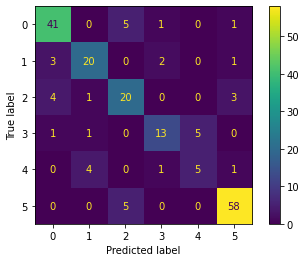

In [90]:
block_predictions = confusion_matrix(y_test_labelled, tree_grid_search.predict(X_test_pca))
disp = ConfusionMatrixDisplay(block_predictions)
disp.plot()

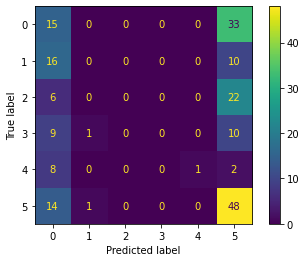

In [91]:
block_predictions_race = confusion_matrix(y_test_labelled, tree_grid_search_race.predict(race_test_pca))
disp2 = ConfusionMatrixDisplay(block_predictions_race)
disp2.plot()